In [92]:
#PLEASE RUN THIS CELL 
import requests
import os
import glob, cv2
import tarfile
import requests
import getpass
import sys
import logging
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.io import imread
import skimage.transform
from scipy.misc import imresize
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop, SGD
from keras.initializers import RandomNormal
from keras.layers import *
import random
from IPython.display import clear_output

from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from imgaug import augmenters as iaa
#os.getcwd()

In [93]:
os.chdir('/jupyteruser/41400447/Project/UTKFace')
# Extract meta data and/or read it into data frames
utkLandmarks = pd.read_csv('img_names.txt',quotechar='"',skipinitialspace=True, delimiter=' ',
                            header=None, usecols=[0])

In [94]:
utkLandmarks = pd.DataFrame(utkLandmarks[0].str.split('_').tolist(),
                                   columns = ['age','gender','race','img_id'])

In [95]:
utkLandmarks['img_file']=utkLandmarks.age+'_'+utkLandmarks.gender+"_"+utkLandmarks.race+'_'+utkLandmarks.img_id
utkLandmarks=utkLandmarks.loc[utkLandmarks['img_file'].str.contains('nan')==False]

In [96]:
utkLandmarks.shape

(23705, 5)

In [97]:
utkLandmarks.img_file.isnull().sum()

0

In [98]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #X[i,] = np.load('data/' + ID + '.npy')   
            #print('samata',ID)
            if str(ID)=='24_0_1_20170116220224657':
                X[i,] =imread('24_0_1_20170116220224657 .jpg.chip.jpg')/255
            else:
                X[i,] =imread(str(ID))/255
            # Store class
            
            y[i] = pd.to_numeric(self.labels[i])
            #print('samata',y[i])
        #return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
        return X, y

In [99]:
im_train, im_test = train_test_split(utkLandmarks, random_state=109)

In [100]:
train_IDs=im_train['img_file'].tolist()
train_labels=im_train['gender'].tolist()

In [101]:
test_IDs=im_test['img_file'].tolist()
test_labels=im_test['gender'].tolist()

In [102]:
train_datagen=DataGenerator(train_IDs, train_labels, batch_size=32, dim=(200,200), n_channels=3, n_classes=2)
test_datagen=DataGenerator(test_IDs, test_labels, batch_size=32, dim=(200,200), n_channels=3, n_classes=2)

### Trial Model

In [103]:
gw_cnn = Sequential() # Create sequential model

# Add convolution layers
gw_cnn.add(Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(200, 200,3)))
#gw_cnn.add(Dropout(0.01))
gw_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = 'hlayer1'))
gw_cnn.add(BatchNormalization())
gw_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', name = 'hlayer2'))
gw_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', name = 'hlayer3'))
gw_cnn.add(BatchNormalization())
gw_cnn.add(MaxPooling2D((2, 2), name = 'hlayer4'))
gw_cnn.add(Conv2D(16, (1, 1), padding='same', activation='relu'))
gw_cnn.add(Conv2D(16, (1, 1), padding='same', activation='relu'))
gw_cnn.add(MaxPooling2D((2, 2)))
gw_cnn.add(Conv2D(8, (1, 1), padding='same', activation='relu'))
gw_cnn.add(Conv2D(8, (1, 1), padding='same', activation='relu'))
gw_cnn.add(MaxPooling2D((2, 2)))
gw_cnn.add(BatchNormalization())
# flatten and add output layer
gw_cnn.add(Flatten())
gw_cnn.add(Dropout(0.01))
gw_cnn.add(Dense(100, activation='relu', name = 'hlayer5'))
gw_cnn.add(Dense(1, activation='sigmoid', name = 'olayer'))
#summary
gw_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_199 (Conv2D)          (None, 200, 200, 64)      4864      
_________________________________________________________________
hlayer1 (Conv2D)             (None, 200, 200, 64)      36928     
_________________________________________________________________
batch_normalization_194 (Bat (None, 200, 200, 64)      256       
_________________________________________________________________
hlayer2 (Conv2D)             (None, 200, 200, 32)      18464     
_________________________________________________________________
hlayer3 (Conv2D)             (None, 200, 200, 32)      9248      
_________________________________________________________________
batch_normalization_195 (Bat (None, 200, 200, 32)      128       
_________________________________________________________________
hlayer4 (MaxPooling2D)       (None, 100, 100, 32)      0         
__________

In [104]:
adam=Adam(lr=0.001, decay=0.01/25)
gw_cnn.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []

    def flip_add_noise(input_img):
    aug = iaa.CoarseDropout(0.02, size_percent=0.7, per_channel=0.7)
    seq_object = iaa.Sequential([aug])
    return seq_object.augment_images([np.fliplr(input_img)])[0].astype('float32')

    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            y=np.random(1, 0.3)
            if y==1 :
                im=flip_add_noise(im)
            else:
                im=im
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

In [105]:
from imgaug import augmenters as iaa
def flip_add_noise(input_img):
    aug = iaa.CoarseDropout(0.02, size_percent=0.7, per_channel=0.7)
    seq_object = iaa.Sequential([aug])
    return seq_object.augment_images([np.fliplr(input_img)])[0].astype('float32')

Index(['age', 'gender', 'race', 'img_id', 'img_file'], dtype='object')

In [106]:
im_train1=im_train.copy()
im_test1=im_test.copy()
im_test1.reset_index(inplace=True)
im_train1['gender']=pd.to_numeric(im_train1['gender'])
im_test1['gender']=pd.to_numeric(im_test1['gender'])

In [116]:
from imgaug import augmenters as iaa
def flip_add_noise(input_img):
    aug = iaa.CoarseDropout(0.02, size_percent=0.7, per_channel=0.7)
    seq_object = iaa.Sequential([aug])
    return seq_object.augment_images([np.fliplr(input_img)])[0].astype('float32')


In [117]:
train_datagen1 = ImageDataGenerator(rescale=1./255)
test_datagen1 = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen1.flow_from_dataframe(dataframe=im_train1, x_col="img_file", y_col="gender", directory='/jupyteruser/41400447/Project/UTKFace',
                                            class_mode="binary", batch_size=32, target_size=(200, 200))
test_generator=test_datagen1.flow_from_dataframe(dataframe=im_test1, x_col="img_file", y_col="gender", directory='/jupyteruser/41400447/Project/UTKFace',
                                            class_mode="binary", batch_size=32, target_size=(200, 200))

Found 17777 images belonging to 2 classes.
Found 5927 images belonging to 2 classes.


In [118]:
test_gen1 = ImageDataGenerator(rescale=1./255, preprocessing_function=flip_add_noise)
test_gen=test_gen1.flow_from_dataframe(dataframe=im_train1, x_col="img_file", y_col="gender", directory='/jupyteruser/41400447/Project/UTKFace',
                                            class_mode="binary", batch_size=32, target_size=(200, 200))   
test_gen2 = ImageDataGenerator(rescale=1./255)
test_gen3=test_gen2.flow_from_dataframe(dataframe=im_train1, x_col="img_file", y_col="gender", directory='/jupyteruser/41400447/Project/UTKFace',
                                            class_mode="binary", batch_size=32, target_size=(200, 200)) 

train_generator1 = zip(test_gen, test_gen3)

Found 17777 images belonging to 2 classes.
Found 17777 images belonging to 2 classes.


In [119]:
%%time
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=test_generator.n//test_generator.batch_size
gw_cnn.fit_generator(generator=train_generator1,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=1)

Epoch 1/1


AttributeError: 'tuple' object has no attribute 'shape'

In [71]:
scores = gw_cnn.evaluate_generator(train_generator,steps=STEP_SIZE_TRAIN) #1514 testing images
print("Train Accuracy = ", scores)
scores = gw_cnn.evaluate_generator(test_generator,steps=STEP_SIZE_VALID) #1514 testing images
print("Validation Accuracy = ", scores)
scores

Train Accuracy =  [0.12104656944756241, 0.9571146801916033]
Validation Accuracy =  [0.35091724795644014, 0.8748091603154545]


[0.35091724795644014, 0.8748091603154545]

### InceptionV3 pre-trained on Imagenet -  Training all layers

In [79]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D

input_shape=Input((200, 200, 3))
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_shape)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
#x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = True

In [80]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 99, 99, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_100 (BatchN (None, 99, 99, 32)   96          conv2d_105[0][0]                 
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 99, 99, 32)   0           batch_normalization_100[0][0]    
__________________________________________________________________________________________________
conv2d_106

In [81]:
epochs=5
learning_rt=0.001
decay_rt=learning_rt/epochs
adam=Adam(lr=learning_rt, decay=decay_rt)
model.compile(optimizer=adam,loss='binary_crossentropy', metrics=['accuracy'])

In [82]:
%%time
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs)

Epoch 1/5
555/555 [==============================] - 381s 686ms/step - loss: 0.3527 - acc: 0.8467 - val_loss: 0.3831 - val_acc: 0.8718
Epoch 2/5
555/555 [==============================] - 361s 651ms/step - loss: 0.2483 - acc: 0.9002 - val_loss: 0.3148 - val_acc: 0.8792
Epoch 3/5
555/555 [==============================] - 360s 649ms/step - loss: 0.2084 - acc: 0.9168 - val_loss: 0.2468 - val_acc: 0.8964
Epoch 4/5
555/555 [==============================] - 361s 650ms/step - loss: 0.1809 - acc: 0.9277 - val_loss: 0.2473 - val_acc: 0.9069
Epoch 5/5
555/555 [==============================] - 362s 653ms/step - loss: 0.1600 - acc: 0.9407 - val_loss: 0.2105 - val_acc: 0.9159
CPU times: user 23min 25s, sys: 8min 2s, total: 31min 28s
Wall time: 30min 34s


In [89]:
scores = gw_cnn.evaluate_generator(train_generator,steps=STEP_SIZE_TRAIN) #1514 testing images
print("Train Accuracy = ", scores)
scores = gw_cnn.evaluate_generator(test_generator,steps=STEP_SIZE_VALID) #1514 testing images
print("Validation Accuracy = ", scores)
scores

Epoch 1/25
 10/555 [..............................] - ETA: 3:52 - loss: 0.0915 - acc: 0.9781

KeyboardInterrupt: 

In [31]:
prediction=model.predict_generator(test_datagen)

In [32]:
prediction

array([[0.3438816 ],
       [0.34388095],
       [0.34388193],
       ...,
       [0.34388116],
       [0.34376916],
       [0.34388193]], dtype=float32)

In [34]:
prediction.max(), prediction.min()

(0.34388238, 0.34309292)

### VGG16 Architecture - Tranining All Layers

In [120]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D

input_shape=Input((200, 200, 3))
base_model = VGG16(include_top=False, input_tensor=input_shape)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
#x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(1, activation='sigmoid')(x)
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = True

In [121]:
model_vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [122]:
epochs=5
learning_rt=0.001
decay_rt=learning_rt/epochs
adam=Adam(lr=learning_rt, decay=decay_rt)
sgd=SGD(lr=learning_rt, decay=decay_rt, momentum=.9)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
model_vgg16.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
%%time
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=test_generator.n//test_generator.batch_size
model_vgg16.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs)

Epoch 1/5
555/555 [==============================] - 469s 845ms/step - loss: 0.4100 - acc: 0.7979 - val_loss: 0.2485 - val_acc: 0.8956
Epoch 2/5
555/555 [==============================] - 460s 828ms/step - loss: 0.2524 - acc: 0.8931 - val_loss: 0.2305 - val_acc: 0.9064
Epoch 3/5
555/555 [==============================] - 460s 828ms/step - loss: 0.2069 - acc: 0.9130 - val_loss: 0.2034 - val_acc: 0.9184
Epoch 4/5
534/555 [===========================>..] - ETA: 15s - loss: 0.1844 - acc: 0.9248

In [ ]:
scores = model_vgg16.evaluate_generator(train_generator,steps=STEP_SIZE_TRAIN) #1514 testing images
print("Train Accuracy = ", scores)
scores = model_vgg16.evaluate_generator(test_generator,steps=STEP_SIZE_VALID) #1514 testing images
print("Validation Accuracy = ", scores)
scores

In [18]:
prediction=model_vgg19.predict_generator(test_datagen)

In [19]:
prediction

array([[0.3649476 ],
       [0.34916738],
       [0.36855856],
       ...,
       [0.3552313 ],
       [0.35575113],
       [0.35387307]], dtype=float32)

In [20]:
prediction.max(), prediction.min()

(0.37395987, 0.31762928)

### ResNet50 

In [25]:
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D

input_shape=Input((200, 200, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_shape)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
#x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(1, activation='sigmoid')(x)
model_rn50 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = True

/usr/share/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [26]:
model_rn50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [29]:
epochs=10
learning_rt=0.001
decay_rt=learning_rt/epochs
adam=Adam(lr=learning_rt, decay=decay_rt)
sgd=SGD(lr=learning_rt, decay=decay_rt, momentum=.9)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, min_delta=0.00001)
model_rn50.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])

In [30]:
%%time
model_rn50.fit_generator(generator=train_datagen, validation_data=test_datagen, epochs=epochs, callbacks=[es], 
                          )

Epoch 1/10
555/555 [==============================] - 490s 883ms/step - loss: 0.6544 - acc: 0.6510 - val_loss: 0.6471 - val_acc: 0.6562
Epoch 2/10
555/555 [==============================] - 483s 871ms/step - loss: 0.6489 - acc: 0.6557 - val_loss: 0.6441 - val_acc: 0.6562
Epoch 3/10
555/555 [==============================] - 481s 867ms/step - loss: 0.6469 - acc: 0.6562 - val_loss: 0.6442 - val_acc: 0.6562
Epoch 4/10
555/555 [==============================] - 481s 867ms/step - loss: 0.6453 - acc: 0.6562 - val_loss: 0.6448 - val_acc: 0.6562
Epoch 5/10
555/555 [==============================] - 479s 862ms/step - loss: 0.6463 - acc: 0.6562 - val_loss: 0.6449 - val_acc: 0.6562
Epoch 00005: early stopping
CPU times: user 26min 40s, sys: 7min 45s, total: 34min 25s
Wall time: 40min 18s


In [16]:

scores = model_rn50.evaluate_generator(train_datagen) #1514 testing images
print("Train Accuracy = ", scores)
scores = model_rn50.evaluate_generator(test_datagen) #1514 testing images
print("Validation Accuracy = ", scores)
scores

Train Accuracy =  [0.6433843855385308, 0.65625]
Validation Accuracy =  [0.64355492462983, 0.65625]


[0.64355492462983, 0.65625]

In [17]:
prediction=model_rn50.predict_generator(test_datagen)

In [18]:
prediction

array([[0.35210323],
       [0.3489794 ],
       [0.34523255],
       ...,
       [0.35372838],
       [0.34447497],
       [0.34803784]], dtype=float32)

In [19]:
prediction.max(), prediction.min()

(0.37161526, 0.30770212)

### Racewise Accuracy

In [8]:
utkLandmarks.head()

,age,gender,race,img_id
0,1,0,2,20161219140530307.jpg
1,1,0,2,20161219140525218.jpg
2,1,0,2,20161219140540938.jpg
3,6,1,2,20161219140554092.jpg
4,1,1,2,20161219140604000.jpg


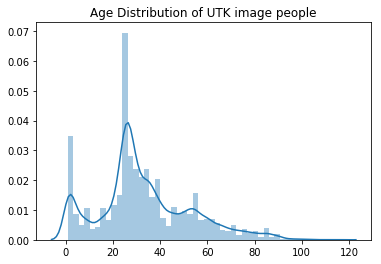

In [17]:
import seaborn as sns
utkLandmarks["age"]=pd.to_numeric(utkLandmarks["age"])
sns.distplot( utkLandmarks["age"].values);
plt.title('Age Distribution of UTK image people');

In [12]:
utkLandmarks.race.value_counts(normalize=True)

0                        0.425089
1                        0.190906
3                        0.167665
2                        0.144846
4                        0.071368
20170109150557335.jpg    0.000042
20170109142408075.jpg    0.000042
20170116174525125.jpg    0.000042
Name: race, dtype: float64

In [18]:
utkLandmarks.gender.value_counts(normalize=True)

0    0.522651
1    0.477265
3    0.000042
     0.000042
Name: gender, dtype: float64

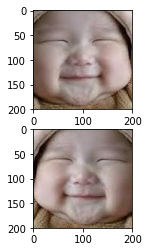

In [30]:
img = (plt.imread('/jupyteruser/41400447/Project/crop_part1/1_0_2_20161219140530307.jpg.chip.jpg'))
plt.subplot(2, 1, 1)
plt.imshow(img)
plt.subplot(2, 1, 2)
plt.imshow(np.fliplr(img))
plt.show()

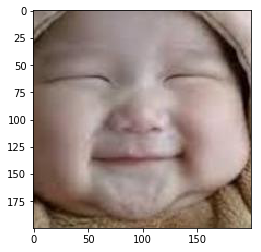

In [2]:
img1 = imread('/jupyteruser/41400447/Project/crop_part1/1_0_2_20161219140530307.jpg.chip.jpg')
plt.imshow(img1)